<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [2]:
# !pip install ydata-profiling scikit-learn==1.3.2

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

**Ответ**: чтобы добиться воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [6]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [7]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
3  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   
4  Individual       Manual   First Owner  20.14 kmpl  1197 CC   81.86 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [8]:
# буду смотреть все пункты по выборке train

In [9]:
# пропуски в колонках - [mileage, engine, max_power, torque, seats]
df_train.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64

In [10]:
assert df_train.shape[0] == df_train.drop_duplicates().shape[0], "Есть дубликаты в датасете"

AssertionError: Есть дубликаты в датасете

In [11]:
# дашборд в одну строку
ProfileReport(df_train, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Выводы**:
1. Датасет по продажам БУ автомобилей
2. Датасет разнороден на признаки - есть и числовые, и категориальные, и текстовые
2. Довольно много дубликатов (почти 15%)
3. Каждое 4 полное название машины уникально
4. Год выпуска машин в основном > 2010
5. Если предположить, что цена в долларах, то машины дороже 200 тысяч долларов
встречаются довольно редко
6. Основная масса машин отъездило до 250 тыся километров
7. На удивление машин на дизеле больше чем на бензине
8. В основном машины продают собственники / перекупы
9. На удивление машин на механике больше чем на автомате
10. Основная масса продающих - первые владельцы машины
11. В освном машины 5-местные
13. 5 колонок из 12 имеют незначительное количетсво пропусков (до 3%)

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [12]:
df_train.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [13]:
df_test.describe()

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [14]:
df_train.describe(include='object')

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [15]:
df_test.describe(include='object')

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

#### **Выводы**:
1. По числовым признакам - и в трейне, и в тесте по медианам и средним похожие значения, нет явных перекосов в выборках
2. По категориальным признакам - тоже все похоже, по тем кат. фичам у которых высокая вариативность понятное дело не все значения есть в маленькой тестовой выборке, но это нормально

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [16]:
print(f'Кол-во дубликатов без целевой переменной: {df_train.shape[0] - df_train.drop_duplicates(subset=["name", "year", "km_driven", "fuel", "seller_type", "transmission", "owner", "mileage", "engine", "max_power", "torque", "seats"]).shape[0]}')

Кол-во дубликатов без целевой переменной: 1159


In [17]:
# дубликаты
df_train_temp = df_train.drop("selling_price", axis=1)
df_train_temp[df_train_temp.duplicated()].sort_values("name", ascending=False)

name  year  km_driven    fuel  \
3035        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
1468        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
2941        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
4349        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
567         Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
...                                    ...   ...        ...     ...   
1337            Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
4485            Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
2787            Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
6704               Audi Q5 3.0 TDI Quattro  2014      76131  Diesel   
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017      22000  Diesel   

     seller_type transmission        owner     mileage   engine   max_power  \
3035  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
1468  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
2941  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
4349  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
567   Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
...          ...          ...          ...         ...      ...         ...   
1337      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
4485      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
2787      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
6704  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   241.4 bhp   
6307      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC  174.33 bhp   

                   torque  seats  
3035                400Nm    5.0  
1468                400Nm    5.0  
2941                400Nm    5.0  
4349                400Nm    5.0  
567                 400Nm    5.0  
...                   ...    ...  
1337  400nm@ 1750-3000rpm    5.0  
4485  400nm@ 1750-3000rpm    5.0  
2787  400nm@ 1750-3000rpm    5.0  
6704  580Nm@ 1400-3250rpm    5.0  
6307  380Nm@ 1750-2500rpm    5.0  

[1159 rows x 12 columns]

In [18]:
df_train = df_train.drop_duplicates(subset=["name", "year", "km_driven", "fuel", "seller_type", "transmission", "owner", "mileage", "engine", "max_power", "torque", "seats"], keep="first")
df_train.reset_index(drop=True, inplace=True)

In [19]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [20]:
df_train.head(10)

name  year  selling_price  km_driven  \
0                Maruti Swift Dzire VDI  2014         450000     145500   
1          Skoda Rapid 1.5 TDI Ambition  2014         370000     120000   
2             Hyundai i20 Sportz Diesel  2010         225000     127000   
3                Maruti Swift VXI BSIII  2007         130000     120000   
4         Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000   
5          Maruti Wagon R LXI DUO BSIII  2007          96000     175000   
6                    Maruti 800 DX BSII  2001          45000       5000   
7                      Toyota Etios VXD  2011         350000      90000   
8  Ford Figo Diesel Celebration Edition  2013         200000     169000   
9       Renault Duster 110PS Diesel RxL  2014         500000      68000   

     fuel seller_type transmission         owner     mileage   engine  \
0  Diesel  Individual       Manual   First Owner   23.4 kmpl  1248 CC   
1  Diesel  Individual       Manual  Second Owner  21.14 kmpl  1498 CC   
2  Diesel  Individual       Manual   First Owner   23.0 kmpl  1396 CC   
3  Petrol  Individual       Manual   First Owner   16.1 kmpl  1298 CC   
4  Petrol  Individual       Manual   First Owner  20.14 kmpl  1197 CC   
5     LPG  Individual       Manual   First Owner  17.3 km/kg  1061 CC   
6  Petrol  Individual       Manual  Second Owner   16.1 kmpl   796 CC   
7  Diesel  Individual       Manual   First Owner  23.59 kmpl  1364 CC   
8  Diesel  Individual       Manual   First Owner   20.0 kmpl  1399 CC   
9  Diesel  Individual       Manual  Second Owner  19.01 kmpl  1461 CC   

    max_power                    torque  seats  
0      74 bhp            190Nm@ 2000rpm    5.0  
1  103.52 bhp       250Nm@ 1500-2500rpm    5.0  
2      90 bhp  22.4 kgm at 1750-2750rpm    5.0  
3    88.2 bhp     11.5@ 4,500(kgm@ rpm)    5.0  
4   81.86 bhp         113.75nm@ 4000rpm    5.0  
5    57.5 bhp      7.8@ 4,500(kgm@ rpm)    5.0  
6      37 bhp             59Nm@ 2500rpm    4.0  
7    67.1 bhp       170Nm@ 1800-2400rpm    5.0  
8    68.1 bhp            160Nm@ 2000rpm    5.0  
9  108.45 bhp            248Nm@ 2250rpm    5.0

In [21]:
df_train.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [22]:
df_train["mileage"] = df_train["mileage"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)
df_train["engine"] = df_train["engine"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)
df_train["max_power"] = df_train["max_power"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)

df_test["mileage"] = df_test["mileage"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)
df_test["engine"] = df_test["engine"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)
df_test["max_power"] = df_test["max_power"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)

<ipython-input-22-9ed8b42bb920>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["mileage"] = df_train["mileage"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)
<ipython-input-22-9ed8b42bb920>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["engine"] = df_train["engine"].apply(lambda x: float(x.split()[0]) if x is not np.nan and len(x.split()) == 2 else np.nan)
<ipython-input-22-9ed8b42bb920>:3: SettingWithCopyWarning: 
A value is trying to be 

Со столбцом `torque` все намного интереснее, он очень грязный, но попробуем разобраться

In [23]:
# функция обрабатывает не все 100% грязных кейсов, но 0.3 балла не стоят стольких сил...
def process_torque(value):
    if pd.isna(value):
        return np.nan, np.nan

    value = re.sub(r"[^\d\.\s\w@\-]", "", value)

    parts = value.split("@")
    if len(parts) != 2:
        return np.nan, np.nan

    torque_part = parts[0].strip()
    rpm_part = parts[1].strip()

    if "kgm" in torque_part:
        torque_match = re.search(r"(\d+\.?\d*)kgm", torque_part)
        if torque_match:
            torque = float(torque_match.group(1)) * 9.8
        else:
            return np.nan, np.nan
    elif "Nm" in torque_part or "nm" in torque_part:
        torque_match = re.search(r"(\d+\.?\d*)(Nm|nm)", torque_part)
        if torque_match:
            torque = float(torque_match.group(1))
        else:
            return np.nan, np.nan
    else:
        return np.nan, np.nan

    rpm_range = rpm_part.replace("rpm", "").strip()
    if "-" in rpm_range:
        rpm_range = rpm_range.split("-")
        max_rpm = max(int(rpm_range[0]), int(rpm_range[1]))
    else:
        max_rpm = int(rpm_range)

    return torque, max_rpm

In [24]:
df_train[["torque", "max_torque_rpm"]] = df_train["torque"].apply(process_torque).apply(pd.Series)
df_test[["torque", "max_torque_rpm"]] = df_test["torque"].apply(process_torque).apply(pd.Series)

<ipython-input-24-23a6147c3489>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[["torque", "max_torque_rpm"]] = df_train["torque"].apply(process_torque).apply(pd.Series)
<ipython-input-24-23a6147c3489>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[["torque", "max_torque_rpm"]] = df_train["torque"].apply(process_torque).apply(pd.Series)


In [25]:
df_train.head(10)

name  year  selling_price  km_driven  \
0                Maruti Swift Dzire VDI  2014         450000     145500   
1          Skoda Rapid 1.5 TDI Ambition  2014         370000     120000   
2             Hyundai i20 Sportz Diesel  2010         225000     127000   
3                Maruti Swift VXI BSIII  2007         130000     120000   
4         Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000   
5          Maruti Wagon R LXI DUO BSIII  2007          96000     175000   
6                    Maruti 800 DX BSII  2001          45000       5000   
7                      Toyota Etios VXD  2011         350000      90000   
8  Ford Figo Diesel Celebration Edition  2013         200000     169000   
9       Renault Duster 110PS Diesel RxL  2014         500000      68000   

     fuel seller_type transmission         owner  mileage  engine  max_power  \
0  Diesel  Individual       Manual   First Owner    23.40  1248.0      74.00   
1  Diesel  Individual       Manual  Second Owner    21.14  1498.0     103.52   
2  Diesel  Individual       Manual   First Owner    23.00  1396.0      90.00   
3  Petrol  Individual       Manual   First Owner    16.10  1298.0      88.20   
4  Petrol  Individual       Manual   First Owner    20.14  1197.0      81.86   
5     LPG  Individual       Manual   First Owner    17.30  1061.0      57.50   
6  Petrol  Individual       Manual  Second Owner    16.10   796.0      37.00   
7  Diesel  Individual       Manual   First Owner    23.59  1364.0      67.10   
8  Diesel  Individual       Manual   First Owner    20.00  1399.0      68.10   
9  Diesel  Individual       Manual  Second Owner    19.01  1461.0     108.45   

   torque  seats  max_torque_rpm  
0  190.00    5.0          2000.0  
1  250.00    5.0          2500.0  
2     NaN    5.0             NaN  
3     NaN    5.0             NaN  
4  113.75    5.0          4000.0  
5     NaN    5.0             NaN  
6   59.00    4.0          2500.0  
7  170.00    5.0          2400.0  
8  160.00    5.0          2000.0  
9  248.00    5.0          2250.0

In [26]:
df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine            float64
max_power         float64
torque            float64
seats             float64
max_torque_rpm    float64
dtype: object

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






#### **Рассуждения по пунктам 2 и 3**:
2. Заполняем медианой потому что она более устойчива к выбросам
3. Правильно - по тренировачным данным для train и test. Это нужно, потому что во время теста мы не знаем статистик по выборке, приходит к нам один пример на инференсе и что для него считать медианой? Именно поэтоу используют статистики полученные во время обучения. Это стандартная процедура во многих ML методах, например всякие скейлинги используют такую технику

In [27]:
df_train.isnull().sum()

name                0
year                0
selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           186
engine            186
max_power         187
torque            703
seats             186
max_torque_rpm    703
dtype: int64

In [28]:
df_test.isnull().sum()

name                0
year                0
selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage            19
engine             19
max_power          19
torque            105
seats              19
max_torque_rpm    105
dtype: int64

In [29]:
columns_to_fillna = ["mileage", "engine", "max_power", "torque", "seats", "max_torque_rpm"]

train_medians = df_train[columns_to_fillna].median()

In [30]:
df_train[columns_to_fillna] = df_train[columns_to_fillna].fillna(train_medians)
df_test[columns_to_fillna] = df_test[columns_to_fillna].fillna(train_medians)

<ipython-input-30-cbe0697fedb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_fillna] = df_train[columns_to_fillna].fillna(train_medians)


In [31]:
# пропусков в трейне не осталось
df_train.isnull().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

In [32]:
# пропусков в тесте не осталось
df_test.isnull().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [33]:
df_train["engine"] = df_train["engine"].astype(int)
df_train["seats"] = df_train["seats"].astype(int)

df_test["engine"] = df_test["engine"].astype(int)
df_test["seats"] = df_test["seats"].astype(int)

<ipython-input-33-5c22f2a748eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["engine"] = df_train["engine"].astype(int)
<ipython-input-33-5c22f2a748eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["seats"] = df_train["seats"].astype(int)


In [34]:
df_train["seats"].value_counts()

seats
5     4618
7      800
8      191
4       94
9       68
6       48
10      18
2        2
14       1
Name: count, dtype: int64

#### **Ответ**:
Колонку seats можно использовать как кат. фичу потому что она имеет достаточно маленькую вариативность

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [35]:
# Такие цифры были до предобработок выше
# TRAIN
# year	selling_price	km_driven	seats
# mean	2013.818403	6.395152e+05	6.958462e+04	5.419008
# 50%	2015.000000	4.500000e+05	6.000000e+04	5.000000

# TEST
# mean	2013.681000	6.179010e+05	71393.341000	5.410805
# 50%	2014.000000	4.349990e+05	61500.000000	5.000000

# ниже две ячейки как стало

In [36]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000    5.840000e+03  
mean     87.948422   170.245901     5.426712    8.187955e+03  
std      31.577884    81.972381     0.982344    2.775918e+05  
min      32.800000    47.040000     2.000000    1.400000e+03  
25%      68.000000   113.000000     5.000000    2.500000e+03  
50%      81.860000   160.000000     5.000000    3.000000e+03  
75%      99.000000   200.000000     5.000000    3.750000e+03  
max     400.000000   789.000000    14.000000    1.500450e+07

In [37]:
df_test.describe()

year  selling_price      km_driven     mileage      engine  \
count  1000.000000   1.000000e+03    1000.000000  1000.00000  1000.00000   
mean   2013.681000   6.179010e+05   71393.341000    19.33881  1454.87600   
std       4.012149   7.585539e+05   48486.218662     3.95175   521.99574   
min    1995.000000   3.100000e+04    1303.000000     0.00000   624.00000   
25%    2011.000000   2.500000e+05   37000.000000    16.55000  1197.00000   
50%    2014.000000   4.349990e+05   61500.000000    19.37000  1248.00000   
75%    2017.000000   6.700000e+05  100000.000000    22.30000  1582.00000   
max    2020.000000   6.000000e+06  375000.000000    32.26000  3604.00000   

         max_power      torque        seats  max_torque_rpm  
count  1000.000000  1000.00000  1000.000000     1000.000000  
mean     90.841670   172.96210     5.403000     3094.896000  
std      34.893389    85.95128     0.912921      842.765364  
min      34.200000    48.00000     4.000000     1500.000000  
25%      69.000000   112.00000     5.000000     2500.000000  
50%      82.425000   160.00000     5.000000     3000.000000  
75%     102.000000   200.00000     5.000000     4000.000000  
max     280.000000   620.00000     9.000000     5200.000000

#### **Ответ**:
По ощущениям и статистикам заполнение пропусков особо не сдвинули распределения фичей, но такое конечно могло произойти. Наверное, не так часто если делать это медианой, и скорее очень часто если делать это средним

## **Визуализации и корреляция (1.6 балла)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натолкнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seaborn`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

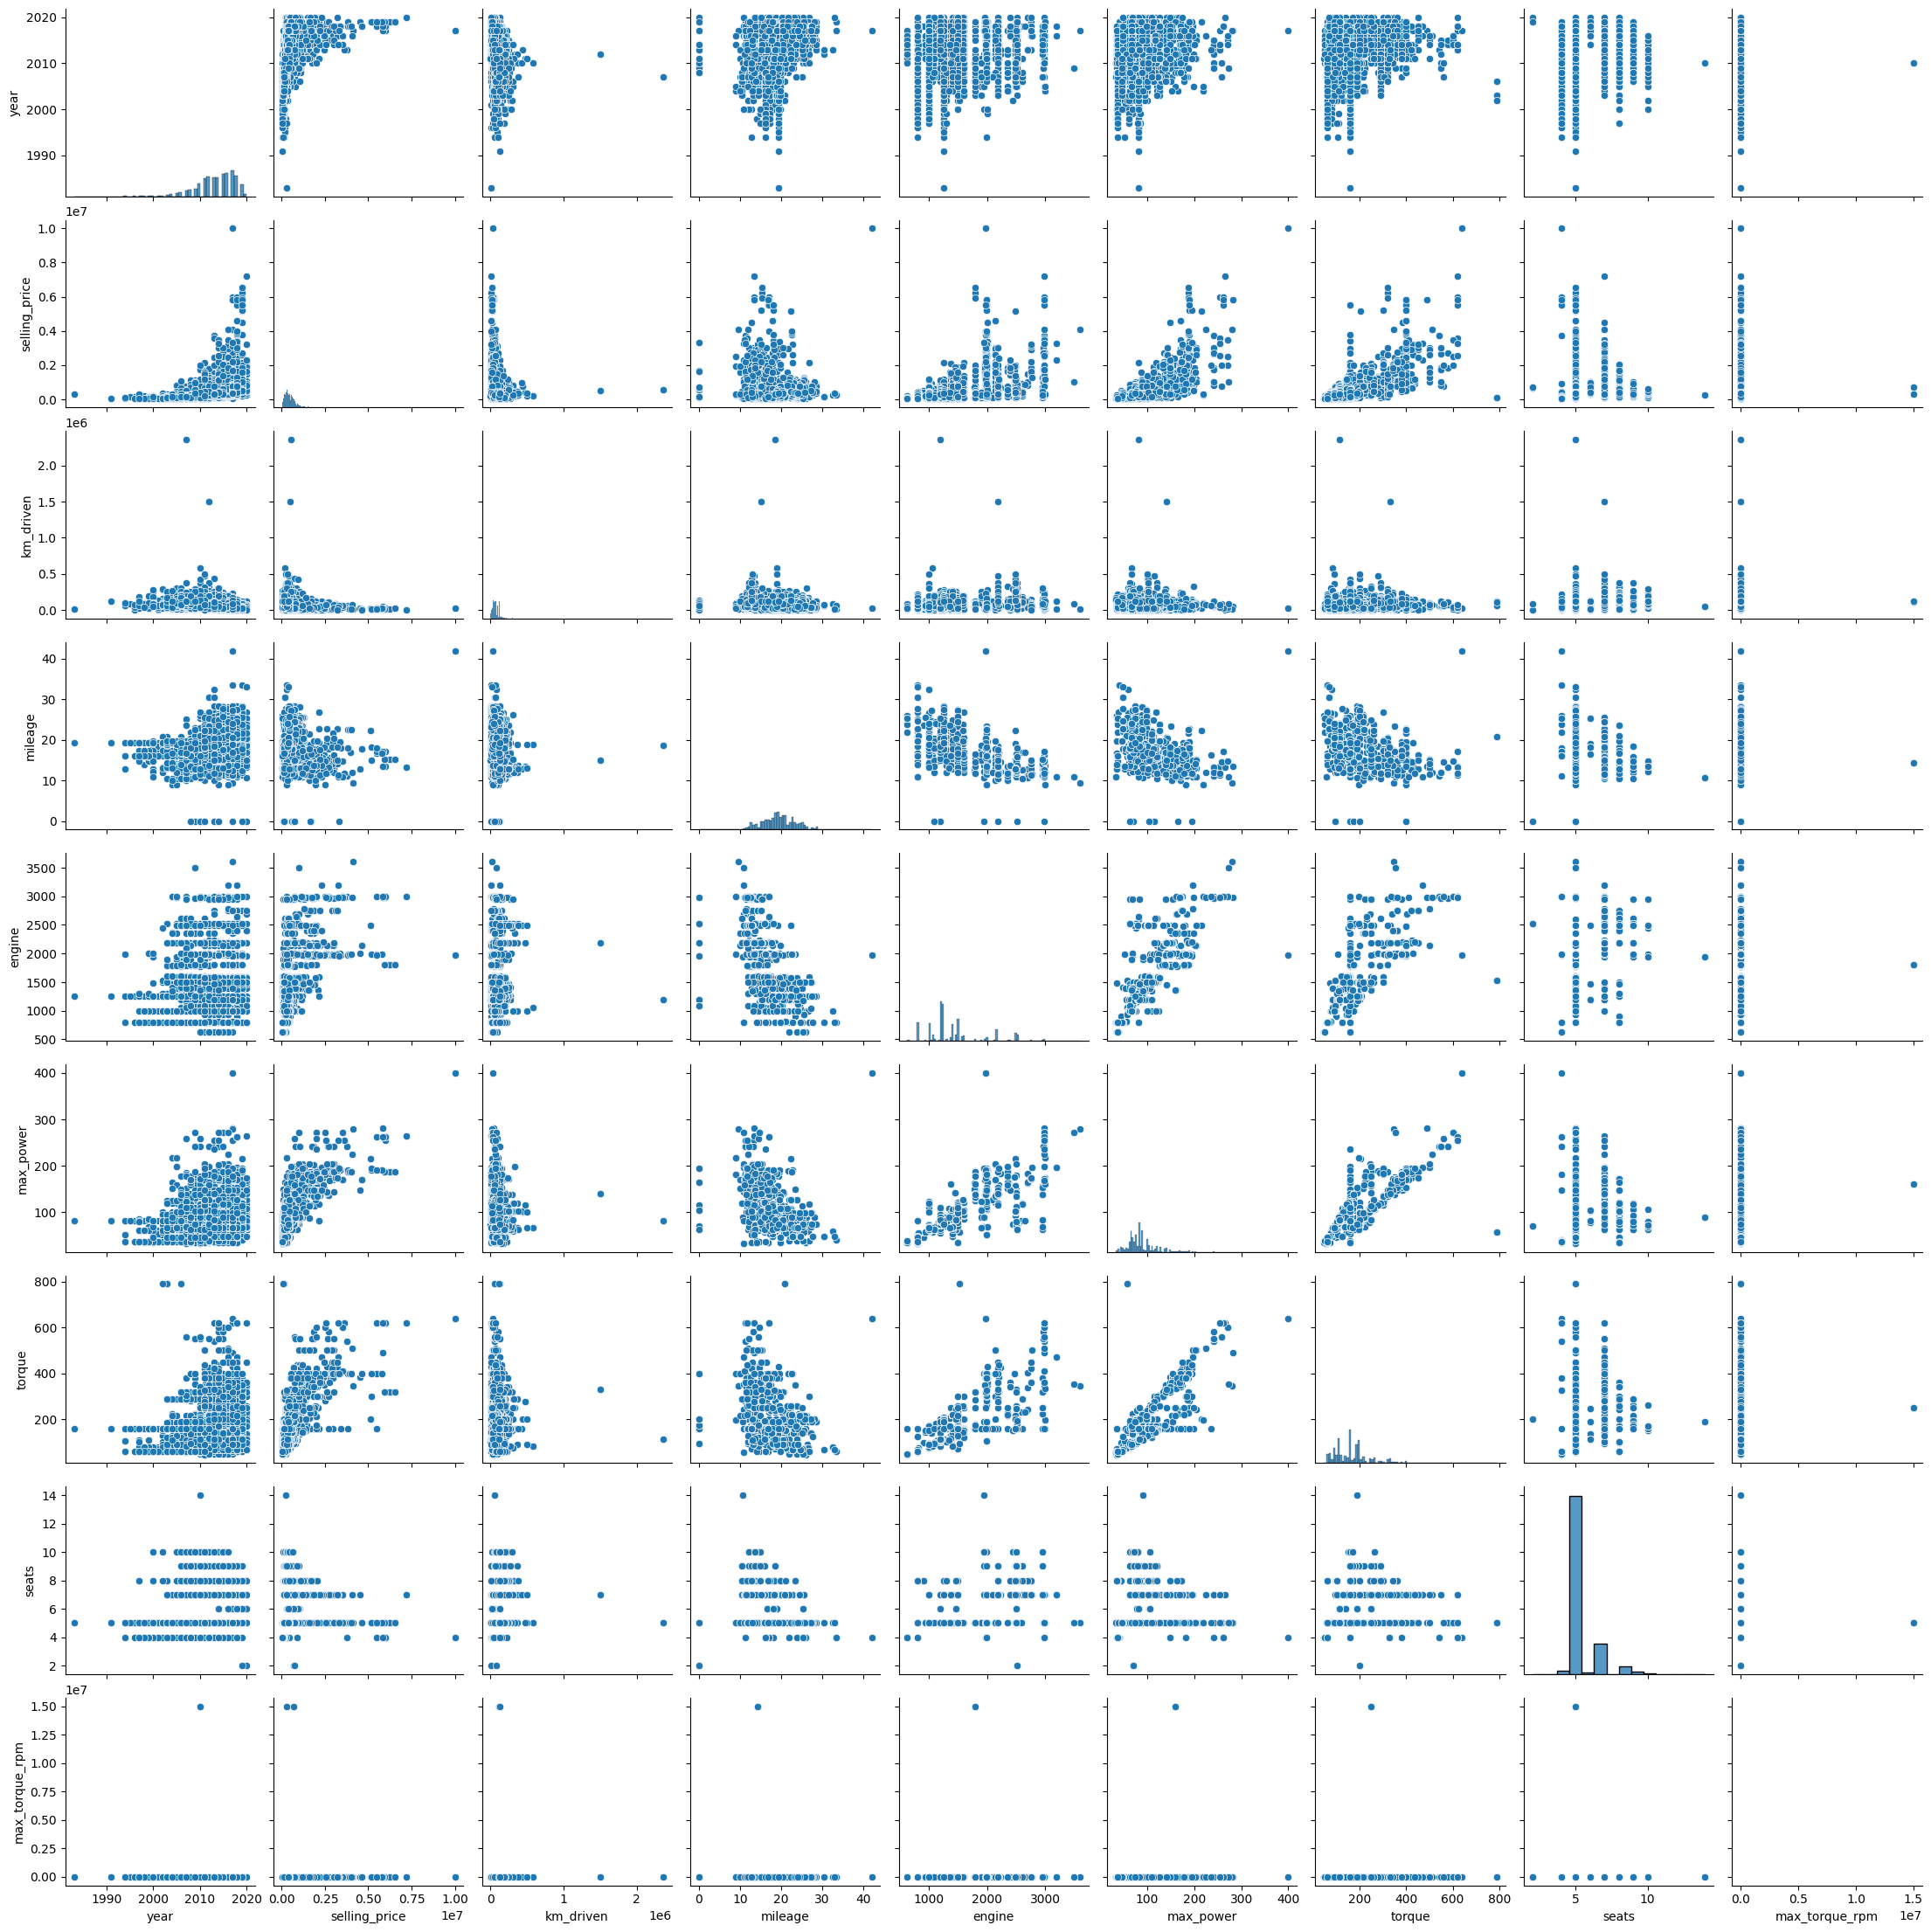

In [216]:
sns.pairplot(df_train)

#### **Ответ ШАГ 1**:

Какие-то корелляции прослеживаются как между признаками, так и таргета с некоторыми признаками


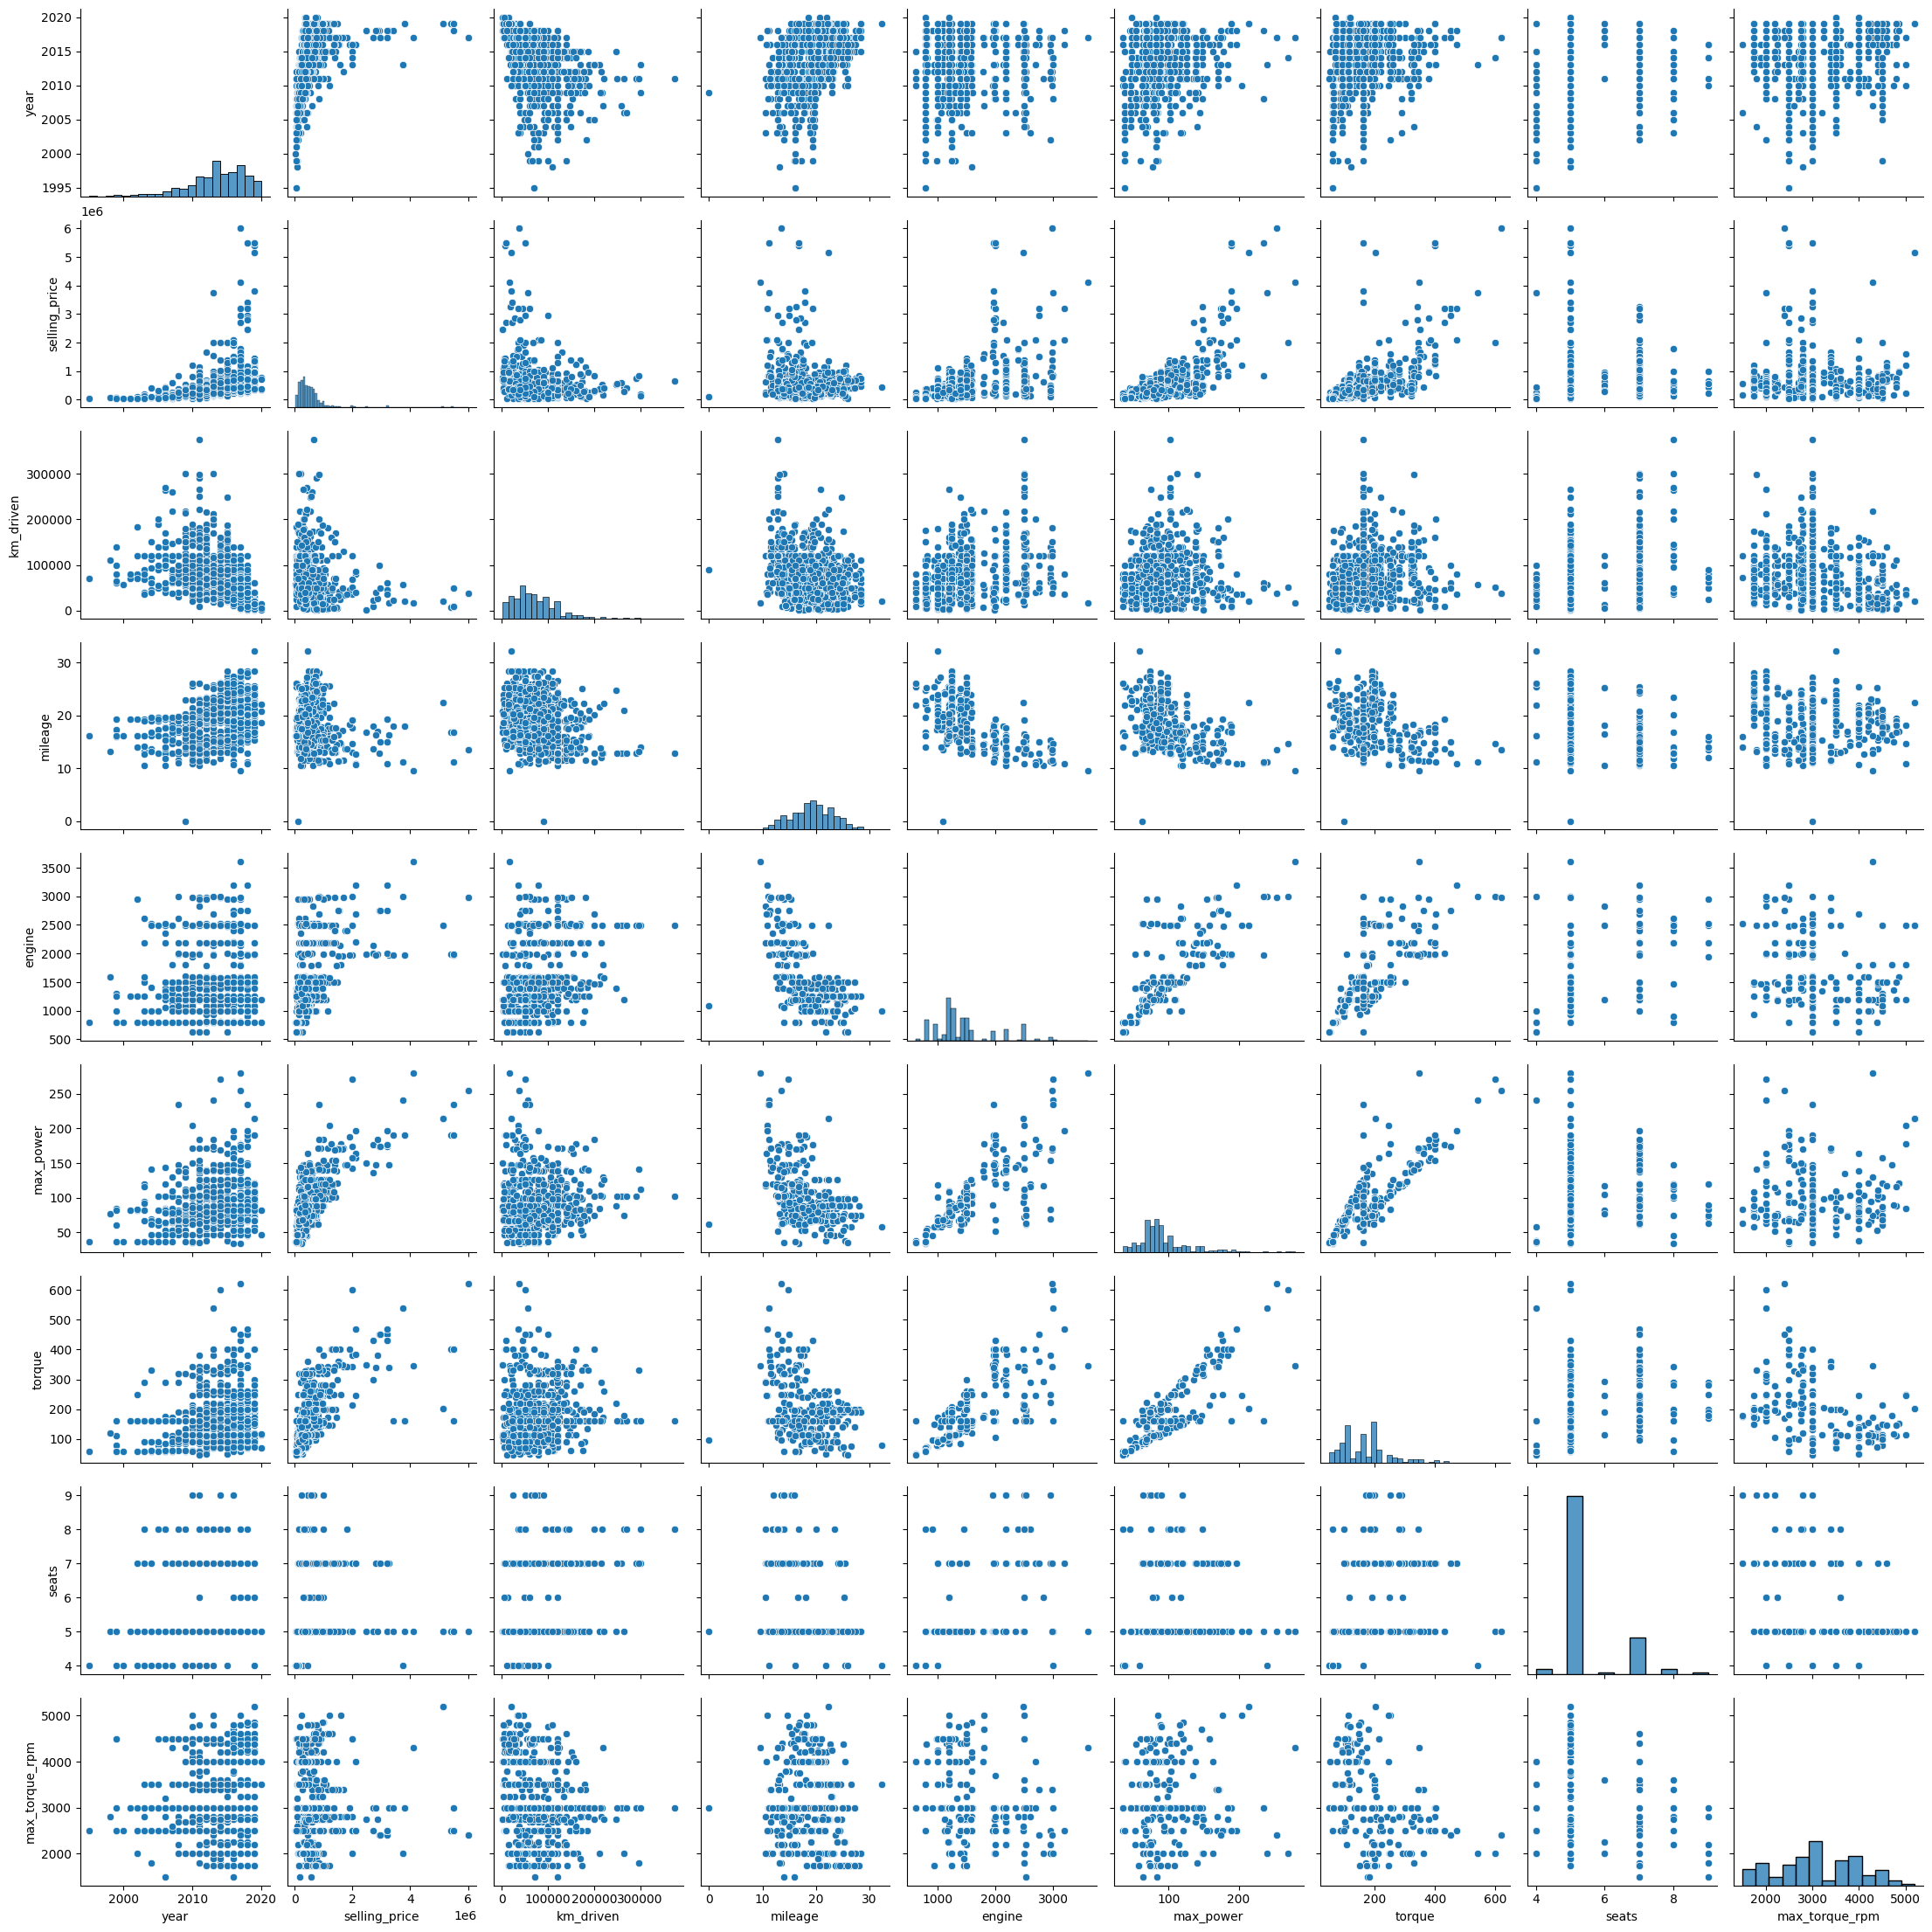

In [217]:
sns.pairplot(df_test)

#### **Ответ ШАГ 2**:

Сходства по некоторым фичам есть

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [38]:
df_train_numeric = df_train.select_dtypes(include=['number'])

In [39]:
df_train_numeric.corr()

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.427279  -0.368966  0.341334  0.002819   
selling_price   0.427279       1.000000  -0.164828 -0.104769  0.447672   
km_driven      -0.368966      -0.164828   1.000000 -0.182086  0.229766   
mileage         0.341334      -0.104769  -0.182086  1.000000 -0.572893   
engine          0.002819       0.447672   0.229766 -0.572893  1.000000   
max_power       0.157138       0.693742   0.024539 -0.374150  0.681968   
torque          0.135145       0.614763   0.119070 -0.226935  0.707700   
seats           0.041178       0.149953   0.192328 -0.451059  0.652172   
max_torque_rpm -0.015346      -0.001106   0.012638 -0.024417  0.013327   

                max_power    torque     seats  max_torque_rpm  
year             0.157138  0.135145  0.041178       -0.015346  
selling_price    0.693742  0.614763  0.149953       -0.001106  
km_driven        0.024539  0.119070  0.192328        0.012638  
mileage         -0.374150 -0.226935 -0.451059       -0.024417  
engine           0.681968  0.707700  0.652172        0.013327  
max_power        1.000000  0.817950  0.244017        0.042072  
torque           0.817950  1.000000  0.351385        0.016618  
seats            0.244017  0.351385  1.000000       -0.008641  
max_torque_rpm   0.042072  0.016618 -0.008641        1.000000

<Axes: >

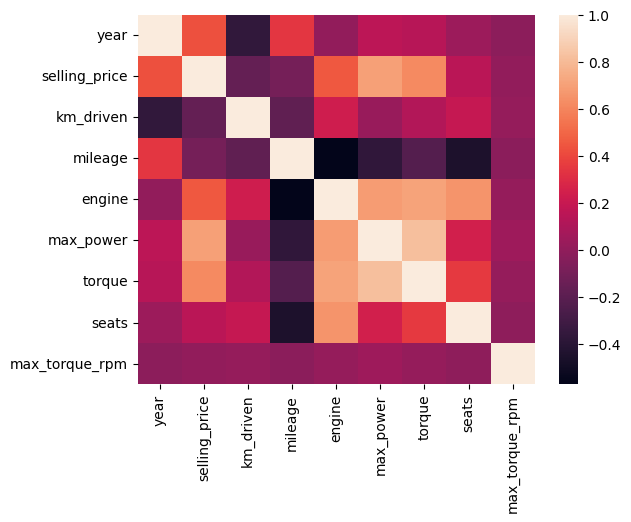

In [40]:
sns.heatmap(df_train_numeric.corr())

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

#### **Ответ**:

1. Кажется таких достаточно много, это у которых коэф корелляции около 0, пусть будет например seats и year
2. max_power и torque
3. В целом да, противоположная корелляция прослеживается

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [41]:
# решил не делать

`Your answer here`

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [42]:
df_train_numeric.head()

year  selling_price  km_driven  mileage  engine  max_power  torque  seats  \
0  2014         450000     145500    23.40    1248      74.00  190.00      5   
1  2014         370000     120000    21.14    1498     103.52  250.00      5   
2  2010         225000     127000    23.00    1396      90.00  160.00      5   
3  2007         130000     120000    16.10    1298      88.20  160.00      5   
4  2017         440000      45000    20.14    1197      81.86  113.75      5   

   max_torque_rpm  
0          2000.0  
1          2500.0  
2          3000.0  
3          3000.0  
4          4000.0

In [43]:
y_train = df_train["selling_price"]
X_train = df_train_numeric.drop("selling_price", axis=1)

In [44]:
# тут стояло (5840, 6), но поставил (5840, 8) так как есть еще несколько столбцов которые подходят
assert X_train.shape == (5840, 8)

In [45]:
y_test = df_test["selling_price"]
X_test = df_test.select_dtypes(include=['number']).drop("selling_price", axis=1)

In [46]:
assert X_test.shape == (1000, 8)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [48]:
train_predicts1 = model1.predict(X_train)
test_predicts1 = model1.predict(X_test)

In [49]:
print(f"TRAIN MSE: {MSE(y_train, train_predicts1)}, TRAIN R2: {r2_score(y_train, train_predicts1)}")
print(f"TEST MSE: {MSE(y_test, test_predicts1)}, TEST R2: {r2_score(y_test, test_predicts1)}")

TRAIN MSE: 114669088116.84549, TRAIN R2: 0.5999520204667329
TEST MSE: 233950415731.74393, TEST R2: 0.5930083614724004


#### **Ответ**:

MSE не дает адекватно оценить качество, потому что квадрат, какое-то огромное число которое почти ни о чем не говорит, нужно извлекать корень и хотя бы посмотреть отклонение от среднего / медианного таргета, R^2 кажется достаточно маленьким для адекватной модели

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [50]:
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - y_mean) ** 2)
    r_squared = 1 - (ssr / sst)
    return r_squared

Формула коэффициента детерминации:

$$ R^2 = 1 - \dfrac{SSR}{SST} $$, где $SSR$ - сумма квадратов разностей между фактическими и предсказанными значениями, а $SST$ - сумма квадратов разностей между фактическими значениями и их средним значением. Чем ближе $R^2$ к 1 тем лучше, так как модель объясняет вариацию целевой переменной.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [52]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
model2 = LinearRegression()
model2.fit(X_train_scaled, y_train)

LinearRegression()

In [54]:
train_predicts2 = model2.predict(X_train_scaled)
test_predicts2 = model2.predict(X_test_scaled)

In [55]:
print(f"TRAIN MSE: {MSE(y_train, train_predicts2)}, TRAIN R2: {r2_score(y_train, train_predicts2)}")
print(f"TEST MSE: {MSE(y_test, test_predicts2)}, TEST R2: {r2_score(y_test, test_predicts2)}")

TRAIN MSE: 114669088116.8455, TRAIN R2: 0.5999520204667328
TEST MSE: 233950415731.7423, TEST R2: 0.5930083614724032


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [56]:
coeffs = model2.coef_

for feature, coef in zip(X_train.columns, coeffs):
    print(f"Признак: {feature}, Коэффициент: {coef:.2f}")

Признак: year, Коэффициент: 157553.75
Признак: km_driven, Коэффициент: -47023.56
Признак: mileage, Коэффициент: 3632.12
Признак: engine, Коэффициент: 28548.77
Признак: max_power, Коэффициент: 266481.59
Признак: torque, Коэффициент: 86720.81
Признак: seats, Коэффициент: -29732.79
Признак: max_torque_rpm, Коэффициент: -10781.58


#### **Ответ**:

Самый важный признак для предсказания цены машины max_power - кол-во л.c. Но явно видно, что нужна регуляризация

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [57]:
from sklearn.linear_model import Lasso

model3 = Lasso()
model3.fit(X_train_scaled, y_train)

Lasso()

In [58]:
train_predicts3 = model3.predict(X_train_scaled)
test_predicts3 = model3.predict(X_test_scaled)

In [59]:
print(f"TRAIN MSE: {MSE(y_train, train_predicts3)}, TRAIN R2: {r2_score(y_train, train_predicts3)}")
print(f"TEST MSE: {MSE(y_test, test_predicts3)}, TEST R2: {r2_score(y_test, test_predicts3)}")

TRAIN MSE: 114669088127.40863, TRAIN R2: 0.5999520204298812
TEST MSE: 233951158831.12674, TEST R2: 0.5930070687402014


In [60]:
coeffs = model3.coef_

for feature, coef in zip(X_train.columns, coeffs):
    print(f"Признак: {feature}, Коэффициент: {coef:.2f}")

Признак: year, Коэффициент: 157553.63
Признак: km_driven, Коэффициент: -47022.51
Признак: mileage, Коэффициент: 3630.10
Признак: engine, Коэффициент: 28544.03
Признак: max_power, Коэффициент: 266481.79
Признак: torque, Коэффициент: 86721.48
Признак: seats, Коэффициент: -29730.08
Признак: max_torque_rpm, Коэффициент: -10780.58


#### **Ответ**:

Ничего не занулилось, возможно у базового Lasso слишком маленький коэф регуляризации или в данных большая скорелированность

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

lasso = Lasso()

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший коэффициент регуляризации: {grid_search.best_params_['alpha']}")
print(f"Лучшая модель: {grid_search.best_estimator_}")

Лучшие параметры: {'alpha': 100}
Лучший коэффициент регуляризации: 100
Лучшая модель: Lasso(alpha=100)


In [63]:
n_models = len(param_grid['alpha']) * 10
print(f"Количество обученных моделей: {n_models}")

Количество обученных моделей: 60


In [64]:
# лучшая модель
model4 = grid_search.best_estimator_

In [65]:
train_predicts4 = model4.predict(X_train_scaled)
test_predicts4 = model4.predict(X_test_scaled)

In [66]:
print(f"TRAIN MSE: {MSE(y_train, train_predicts4)}, TRAIN R2: {r2_score(y_train, train_predicts4)}")
print(f"TEST MSE: {MSE(y_test, test_predicts4)}, TEST R2: {r2_score(y_test, test_predicts4)}")

TRAIN MSE: 114669200048.7854, TRAIN R2: 0.5999516299678884
TEST MSE: 234025106498.01724, TEST R2: 0.5928784257454072


In [67]:
coeffs = model4.coef_

for feature, coef in zip(X_train.columns, coeffs):
    print(f"Признак: {feature}, Коэффициент: {coef:.2f}")

Признак: year, Коэффициент: 157541.97
Признак: km_driven, Коэффициент: -46914.64
Признак: mileage, Коэффициент: 3425.12
Признак: engine, Коэффициент: 28047.36
Признак: max_power, Коэффициент: 266515.36
Признак: torque, Коэффициент: 86788.64
Признак: seats, Коэффициент: -29450.83
Признак: max_torque_rpm, Коэффициент: -10681.62


#### **Ответ**:

1. 60 моделей
2. заполнил только aplha - коэф регуляризации, а весь их набор это те которые нужно перебрать гридсерчу
3. лучший коэф alpha=100, веса никакие не занулились

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [68]:
from sklearn.linear_model import ElasticNet

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_net = ElasticNet()

grid_search = GridSearchCV(elastic_net, param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший коэффициент регуляризации: {grid_search.best_params_['alpha']}")
print(f"Лучшее соотношение L1 и L2: {grid_search.best_params_['l1_ratio']}")
print(f"Лучшая модель: {grid_search.best_estimator_}")

Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.7}
Лучший коэффициент регуляризации: 0.1
Лучшее соотношение L1 и L2: 0.7
Лучшая модель: ElasticNet(alpha=0.1, l1_ratio=0.7)


In [69]:
n_models = len(param_grid['alpha']) * len(param_grid['l1_ratio']) * 10
print(f"Количество обученных моделей: {n_models}")

Количество обученных моделей: 300


In [70]:
# лучшая модель
model5 = grid_search.best_estimator_

In [71]:
train_predicts5 = model5.predict(X_train_scaled)
test_predicts5 = model5.predict(X_test_scaled)

In [72]:
print(f"TRAIN MSE: {MSE(y_train, train_predicts5)}, TRAIN R2: {r2_score(y_train, train_predicts5)}")
print(f"TEST MSE: {MSE(y_test, test_predicts5)}, TEST R2: {r2_score(y_test, test_predicts5)}")

TRAIN MSE: 114784228963.98404, TRAIN R2: 0.5995503266535529
TEST MSE: 237522142005.53952, TEST R2: 0.5867948109471859


In [73]:
coeffs = model5.coef_

for feature, coef in zip(X_train.columns, coeffs):
    print(f"Признак: {feature}, Коэффициент: {coef:.2f}")

Признак: year, Коэффициент: 154705.21
Признак: km_driven, Коэффициент: -48525.20
Признак: mileage, Коэффициент: 1907.08
Признак: engine, Коэффициент: 34299.89
Признак: max_power, Коэффициент: 248077.56
Признак: torque, Коэффициент: 95630.75
Признак: seats, Коэффициент: -31542.45
Признак: max_torque_rpm, Коэффициент: -10013.99


#### **Ответ**:

1. 300 моделей
2. alpha=0.1, l1_ratio=0.7

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [74]:
# решил не делать

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [75]:
df_train["name"].value_counts()

name
Maruti Swift Dzire VDI                          91
Maruti Alto 800 LXI                             58
Maruti Alto LXi                                 56
Maruti Swift VDI                                48
Maruti Swift VDI BSIV                           47
                                                ..
Honda Amaze S AT i-Vtech                         1
Honda Jazz 1.2 SV i VTEC                         1
Maruti Baleno Zeta                               1
Honda Civic 1.8 (E) MT                           1
Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV     1
Name: count, Length: 1924, dtype: int64

оставлю только саму марку машины

In [76]:
df_train["name"] = df_train["name"].apply(lambda x: x.split()[0])
df_test["name"] = df_test["name"].apply(lambda x: x.split()[0])

<ipython-input-76-eb1bd75e827e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["name"] = df_train["name"].apply(lambda x: x.split()[0])


In [77]:
df_train["name"].value_counts()[:10]

name
Maruti        1804
Hyundai       1058
Mahindra       611
Tata           534
Toyota         309
Ford           308
Honda          308
Chevrolet      188
Renault        171
Volkswagen     153
Name: count, dtype: int64

In [78]:
X_train_cat = df_train.copy().drop("selling_price", axis=1)
X_test_cat = df_test.copy().drop("selling_price", axis=1)

In [79]:
# тоже тут (5840, 11) стояло, возможно потому что torque дропали а не удваивали
assert X_train_cat.shape == (5840, 13)

In [80]:
X_train_cat.describe(include='object')

name    fuel seller_type transmission        owner
count     5840    5840        5840         5840         5840
unique      30       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1804    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [81]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas

ohe = OneHotEncoder(sparse_output = False, handle_unknown="ignore", drop="first")

In [82]:
categorical_columns = ["name", "fuel", "seller_type", "transmission", "owner", "seats"]

In [83]:
X_train_encoded = ohe.fit_transform(X_train_cat[categorical_columns])
X_test_encoded = ohe.transform(X_test_cat[categorical_columns])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [84]:
import pickle
with open("ohe.pkl", "wb") as f:
    pickle.dump(ohe, f)

In [85]:
feature_names = ohe.get_feature_names_out(categorical_columns)

In [86]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names)

In [87]:
X_train_ohe = pd.concat([X_train_cat.drop(categorical_columns, axis=1), X_train_encoded_df], axis=1)
X_test_ohe = pd.concat([X_test_cat.drop(categorical_columns, axis=1), X_test_encoded_df], axis=1)

In [88]:
X_train_ohe.head()

year  km_driven  mileage  engine  max_power  torque  max_torque_rpm  \
0  2014     145500    23.40    1248      74.00  190.00          2000.0   
1  2014     120000    21.14    1498     103.52  250.00          2500.0   
2  2010     127000    23.00    1396      90.00  160.00          3000.0   
3  2007     120000    16.10    1298      88.20  160.00          3000.0   
4  2017      45000    20.14    1197      81.86  113.75          4000.0   

   name_Audi  name_BMW  name_Chevrolet  ...  owner_Test Drive Car  \
0        0.0       0.0             0.0  ...                   0.0   
1        0.0       0.0             0.0  ...                   0.0   
2        0.0       0.0             0.0  ...                   0.0   
3        0.0       0.0             0.0  ...                   0.0   
4        0.0       0.0             0.0  ...                   0.0   

   owner_Third Owner  seats_4  seats_5  seats_6  seats_7  seats_8  seats_9  \
0                0.0      0.0      1.0      0.0      0.0      0.0      0.0   
1                0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2                0.0      0.0      1.0      0.0      0.0      0.0      0.0   
3                0.0      0.0      1.0      0.0      0.0      0.0      0.0   
4                0.0      0.0      1.0      0.0      0.0      0.0      0.0   

   seats_10  seats_14  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0  

[5 rows x 54 columns]

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

#### **Ответы**:
1. Обучать на трейне, трансформить и на трейне и на тесте
2. Чтобы избежать мультиколлинеарности
3. Не совсем верно так делать, каждый столбец грубо говоря это одна категория по фиче из начального датасета, удаляя столбец - мы удаляем знание об этой категории

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [89]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [90]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=10, scoring="r2")
grid_search.fit(X_train_ohe, y_train)

# Вывод результатов
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший коэффициент регуляризации: {grid_search.best_params_['alpha']}")
print(f"Лучшая модель: {grid_search.best_estimator_}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.43192e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.21647e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.21638e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.43192e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarnin

Лучшие параметры: {'alpha': 1}
Лучший коэффициент регуляризации: 1
Лучшая модель: Ridge(alpha=1)


In [91]:
# лучшая модель
model6 = grid_search.best_estimator_

In [92]:
import pickle
with open("model.pkl",'wb') as f:
    pickle.dump(model6, f)

In [93]:
train_predicts6 = model6.predict(X_train_ohe)
test_predicts6 = model6.predict(X_test_ohe)

In [94]:
print(f"TRAIN MSE: {MSE(y_train, train_predicts6)}, TRAIN R2: {r2_score(y_train, train_predicts6)}")
print(f"TEST MSE: {MSE(y_test, test_predicts6)}, TEST R2: {r2_score(y_test, test_predicts6)}")

TRAIN MSE: 64070820650.53944, TRAIN R2: 0.7764750486009905
TEST MSE: 124155996058.46953, TEST R2: 0.7840121287632044


#### **Ответ**:

Качество MSE и R^2 сильно лучше чем во всех предыдущих подходах

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [95]:
def business_metric(y_true, y_pred, diff=0.1):
    """
    Считает долю прогнозов, отличающихся не больше чем на
    diff относительно реальных цен
    """
    lower_bounds = y_true * (1 - diff)
    upper_bounds = y_true * (1 + diff)

    normal_preds = (y_pred >= lower_bounds) & (y_pred <= upper_bounds)

    return np.mean(normal_preds)

In [96]:
print(f"Доля прогнозов, с разницей меньше 10% с реальными значениями:")
print(f"Модель 1: {business_metric(y_test, test_predicts1)}")
print(f"Модель 2: {business_metric(y_test, test_predicts2)}")
print(f"Модель 3: {business_metric(y_test, test_predicts3)}")
print(f"Модель 4: {business_metric(y_test, test_predicts4)}")
print(f"Модель 5: {business_metric(y_test, test_predicts5)}")
print(f"Модель 6: {business_metric(y_test, test_predicts6)}")

Доля прогнозов, с разницей меньше 10% с реальными значениями:
Модель 1: 0.24
Модель 2: 0.24
Модель 3: 0.24
Модель 4: 0.239
Модель 5: 0.247
Модель 6: 0.298


#### **Ответ**:

Лучшая модель по такой бизнес метрике все еще последняя (как по MSE и R^2), но если смотреть в целом - выглядит как достаточно слабая модель с такой долей

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [97]:
def your_business_metrics(y_true, y_pred, nedo_pred_weight=2, pere_pred_weight=1):
    """
    Считает кастомную метрику, что-то типа взвешенного MSE на разные типы
    предсказаний, за недопрогноз штраф больше чем за перепрогноз
    """
    weights = np.where(y_pred < y_true, nedo_pred_weight, pere_pred_weight)

    custom_metric = np.mean(weights * (y_true - y_pred)**2)

    return custom_metric

In [98]:
print(f"Кастомная метрика с учетом бизнес потребностей:")
print(f"Модель 1: {your_business_metrics(y_test, test_predicts1)}")
print(f"Модель 2: {your_business_metrics(y_test, test_predicts2)}")
print(f"Модель 3: {your_business_metrics(y_test, test_predicts3)}")
print(f"Модель 4: {your_business_metrics(y_test, test_predicts4)}")
print(f"Модель 5: {your_business_metrics(y_test, test_predicts5)}")
print(f"Модель 6: {your_business_metrics(y_test, test_predicts6)}")

Кастомная метрика с учетом бизнес потребностей:
Модель 1: 441795748767.0479
Модель 2: 441795748767.0451
Модель 3: 441797370991.77374
Модель 4: 441958684481.3535
Модель 5: 449821047818.0284
Модель 6: 219803071218.08075


#### **Ответ**:

По этой бизнес метрике последняя модель также лучшая (как по MSE и R^2), буду ее заворачивать в FastAPI

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
from fastapi import FastAPI, File, UploadFile
from pydantic import BaseModel
from typing import List
import pandas as pd
import pickle

app = FastAPI()


with open("model_artifacts/model.pkl",'rb') as f:
    model = pickle.load(f)

with open("model_artifacts/ohe.pkl",'rb') as f:
    ohe = pickle.load(f)


class Item(BaseModel):
    name: str
    year: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: float
    engine: int
    max_power: float
    torque: float
    max_torque_rpm: float
    seats: float


class Items(BaseModel):
    objects: List[Item]


def transform_features(item_df: pd.DataFrame):
    categorical_columns = ["name", "fuel", "seller_type", "transmission", "owner", "seats"]
    item_encoded = ohe.transform(item_df[categorical_columns])
    item_df = pd.concat([item_df.drop(categorical_columns, axis=1), pd.DataFrame(item_encoded, columns=ohe.get_feature_names_out(categorical_columns))], axis=1)
    return item_df


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    item_df = pd.DataFrame([item.dict()])
    item_df = transform_features(item_df)
    prediction = model.predict(item_df)
    return float(prediction[0])


@app.post("/predict_items")
def predict_items(items: Items) -> List[float]:
    item_list = items.objects
    item_df = pd.DataFrame([item.dict() for item in item_list])
    item_df = transform_features(item_df)
    predictions = model.predict(item_df)
    return predictions.tolist()


@app.post("/predict_csv")
async def predict_csv(file: UploadFile = File(...)):
    df = pd.read_csv(file.file)
    df = transform_features(df)
    predictions = model.predict(df)
    df["predicted_price"] = predictions
    result_file = "data_artifacts/cars_predicted_prices.csv"
    df.to_csv(result_file, index=False)
    return result_file

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит